# CV for ARX model

Various CV schemes for the ARX model used in the ARX paper. This notebook cross-checks those results using MCMC.

The ARX(1,q) model is
$$y_t = \phi y_{t-1} + z_t^\top\beta + \sigma\varepsilon_t$$
where $\varepsilon_t\sim\mathcal{N}\left(0,1\right)$ and the priors are
$$\beta \sim \mathcal{N}(\mu_0,\sigma^2\Sigma_0),\quad \sigma \sim \mathcal{IG}\left(a_0, b_0\right),\quad \phi \sim \mathcal{B}\left(c_0, d_0\right).$$

We'll generate data then perform various forms of cross-validation.

In [8]:
from typing import NamedTuple
from chex import assert_rank, Array, PRNGKey
import jax
import jax.numpy as jnp
from jax.numpy import sqrt, eye, diag, ones
from jax.numpy.linalg import solve
from jax.random import normal
from tensorflow_probability.substrates.jax import bijectors as tfb
from tensorflow_probability.substrates.jax import distributions as tfd
import matplotlib.pyplot as plt

## Model definition

In [4]:
# simulation parameters
phi_star = jnp.array([0.5, 0.3])
beta_star = jnp.array([1.0, 2.0, 3.0])
p, q = len(phi_star), len(beta_star)

# prior parameters
a_0 = 1.0
b_0 = 1.0
c_0 = 1.0
d_0 = 1.0
mu_0 = beta_star
sigma_0_tril = jnp.eye(q)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
def make_L(phi: Array, T: int):
    assert_rank(phi, 1)  # vector
    L = jnp.eye(T)
    for i in range(len(phi)):
        L += jnp.diag(jnp.repeat(-phi[i], T - 1 - i), k=-i - 1)
    return L

def simulate(theta_star, T, Z, key: PRNGKey) -> Array:
    """Simulate ARX model
    
    Args:
        theta_star: model parameters (constrained space)
        T: number of time points
        Z: design matrix
        key: PRNG key
    
    Returns:
        T-vector of simulated data
    """
    phi, beta, sigsq = theta_star
    L = make_L(phi, T)
    mstar = solve(L, Z @ beta)
    eps = normal(key, shape=(T,))
    return mstar + jnp.sqrt(sigsq) * solve(L, eps)

class Theta(NamedTuple):
    """Model parameter type"""
    phi: Array  # shape (p,)
    beta: Array  # shape (q,)
    sigsq: Array  # shape (,)

# parameter space transformations for MCMC
sigsq_tfm = tfb.Exp()
phi_tfm = tfb.Sigmoid(low=-1, high=1)

def forward_transform(theta: Theta) -> Theta:
    """Map to constrained parameter space"""
    return Theta(phi=phi_tfm.forward(theta.phi), beta=theta.beta, sigsq=sigsq_tfm.forward(theta.sigsq))

def inverse_transform(theta: Theta) -> Theta:
    """Map to unconstrained parameter space"""
    return Theta(phi=phi_tfm.inverse(theta.phi), beta=theta.beta, sigsq=sigsq_tfm.inverse(theta.sigsq))

sigsq_prior = tfd.InverseGamma(concentration=a_0, scale=1./b_0)
phi_prior = tfd.Beta(concentration1=c_0, concentration0=d_0)
beta_prior = lambda sigsq: tfd.MultivariateNormalTriL(loc=mu_0, scale_tril=sqrt(sigsq) * sigma_0_tril)

def log_density_constrained(theta: Theta, Z: Array, y: Array, S_train) -> Array:
    """Joint log density of ARX model

    Args:
        theta: model parameters in *constrained* space
        Z: matrix of exogenous regressors
        y: observations
        S_train: selection matrix for training data
    
    Returns:
        log joint density, a scalar
    """
    phi, beta, sigsq = theta
    T = Z.shape[0]
    L = make_L(phi, T)
    mstar = solve(L, Z @ beta)
    cond_data_dist = tfd.MultivariateNormalTriL(loc=S_train @ mstar, scale_tril=sqrt(sigsq) * S_train @ L)
    llik = cond_data_dist.log_prob(S_train @ y)
    lprior = (
        phi_prior.log_prob(phi)
        + sigsq_prior.log_prob(sigsq)
        + beta_prior(sigsq).log_prob(beta)
    )
    return llik + lprior

def log_density_unconstrained(theta: Theta, Z: Array, y: Array, S_train) -> Array:
    """Joint log density of ARX model

    Args:
        theta: model parameters in *unconstrained* space
        Z: matrix of exogenous regressors
        y: observations
        S_train: selection matrix for training data
    
    Returns:
        log joint density, a scalar
    """
    theta_c = forward_transform(theta)
    log_det = (
        phi_tfm.forward_log_det_jacobian(theta.phi)
        + sigsq_tfm.forward_log_det_jacobian(theta.sigsq)
    )
    return log_det + log_density_constrained(theta_c, Z, y, S_train)

def log_pred_density(theta: Theta, y_tilde: Array, Z: Array, S_pred: Array) -> Array:
    """Log predictive density of y given theta
    
    Args:
        theta: model parameters in constrained space
        y_tilde: point at which to evaluate density (full length)
        Z: matrix of exogenous regressors
        S_pred: selection matrix for prediction data
    
    Returns:
        log predictive density, a scalar
    """
    phi, beta, sigsq = theta
    T = Z.shape[0]
    L = make_L(phi, T)
    Linv = solve(L, jnp.eye(T))
    mstar = solve(L, Z @ beta)
    pred_data_dist = tfd.MultivariateNormalTriL(loc=S_pred @ mstar, scale_tril=sqrt(sigsq) * S_pred @ Linv)
    return pred_data_dist.log_prob(S_pred @ y_tilde)

def init_pos(key: PRNGKey) -> Theta:
    """Generate initial positions, in *unconstrained* space"""
    phi_k, beta_k, sigsq_k = jax.random.split(key, 3)
    phi = phi_prior.sample(seed=phi_k)
    sigsq = sigsq_prior.sample(seed=sigsq_k)
    beta = beta_prior(sigsq).sample(seed=beta_k)
    return inverse_transform(Theta(phi, beta, sigsq))

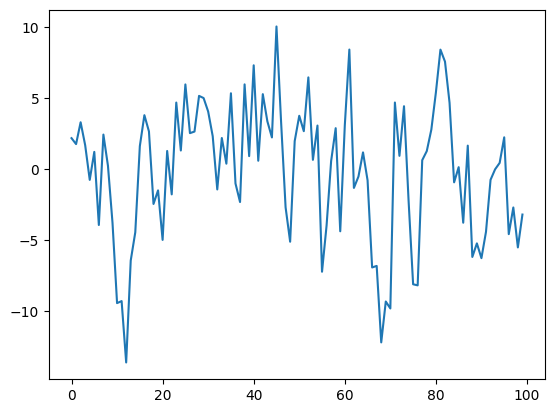

In [9]:
Z_key, y_key = jax.random.split(jax.random.PRNGKey(0), 2)

Z = normal(Z_key, shape=(100, q))
y = simulate(Theta(phi_star, beta_star, 1.0), 100, Z, jax.random.PRNGKey(0))
plt.plot(y)